# **`flygym`-MuJoCo tutorial**

<a target="_blank" href="https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/flygym_mujoco_tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE: You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."**

See [GitHub repo](https://github.com/NeLy-EPFL/flygym) for code and [documentation here](https://nely-epfl.github.io/flygym/).

In particular, you're encouraged to read the following pages on the documentation before proceeding with this tutorial:
- [The NeuroMechFly Model](https://nely-epfl.github.io/flygym/neuromechfly.html)
- [Interacting with an Environment](https://nely-epfl.github.io/flygym/environments/index.html)

In [1]:
#@title Install `flygym` on Colab

# This block is modified from dm_control's tutorial notebook
# https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb

import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

print('Installing flygym')
!pip install -q --progress-bar=off 'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git'

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during dm_control installation. Check the shell '
        'output above for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')
else:
    del pixels, suite

print('Checking that the flygym installation succeeded...')
try:
    import flygym
    from flygym import envs
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during flygym installation. Check the shell '
        'output above for more information.\n')
else:
    del envs, flygym

Installing flygym
  Preparing metadata (setup.py) ... done
env: MUJOCO_GL=egl
Checking that the dm_control installation succeeded...
Checking that the flygym installation succeeded...


## Actuating joints with position control

In this example, we apply position control to all leg joints; that is, at each time step, we assign a target angular position to each joint, and the physics simulator (taking into account certain gain factors) will calculate the appropriate force to apply. As a demo, we will just actuate all leg joints with sine waves.

We start by importing the required libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import flygym.util.config as config
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo

Next, we initiate a new Gym environment. Note that under the 'saved' rendering mode, the video of the simulation will be saved to the specified output directory:

In [3]:
out_dir = Path('data/mujoco_basic_untethered_sinewave')
nmf = NeuroMechFlyMuJoCo(render_mode='saved', output_dir=out_dir,
                         actuated_joints=config.all_leg_dofs)

We then define the frequency, phase, and amplitude of the sinusoidal waves:

In [4]:
freq = 500
phase = 2 * np.pi * np.random.rand(len(nmf.actuators))
amp = 0.9

We are now ready to run the simulation. We do this in a loop, and this is the core of the simulation. We will simulate 0.1 seconds of fly behavior and append the state observations to a list:

In [5]:
run_time = 0.1
obs_list = []    # keep track of the observed states
while nmf.curr_time <= run_time:    # main loop
    joint_pos = amp * np.sin(freq * nmf.curr_time + phase)  # sine wave controller
    action = {'joints': joint_pos}
    obs, info = nmf.step(action)
    nmf.render()
    obs_list.append(obs)
nmf.close()

There are a few things to note here:

First, note that in each iteration, we step the simulation by one step. We give the simulator an **action**, and the physics simulator returns us an **observation** and a dictionary containing additional information:

- The **action** here is a dictionary containing the key `'joints'`. It maps to a NumPy array of control inputs to the actuators. We are using position control, so the array is interpreted as target joint position. If we were using velocity or force control, this array will be interpreted as such. Precisely, the `'joints'` array has a shape of (num_dofs).  The ordering is the same as `nmf.actuated_joints`.

- The **observation** here is a dictionary containing the keys `'joints'` and `'fly'`. These are the state of the joints (angular position, velocity, force) and of the fly (cartesian position and orientation of the thorax in the arena). Precisely, the `'joints'` array has a shape of (3, num_dofs). The 0th, 1st, and 2nd rows are the angular position, velocity, and force at each DoF. The ordering is the same as `nmf.actuated_joints`. The `'fly'` array has a shape of (4, 3). The 0th and 1st rows are the cartesian position and velocity of the fly in the arena in x, y, z directions (taking measurement from the thorax). The 2nd and 3rd rows are the orientation (rotation) of the fly along each axis, and the rate of change thereof.

Second, note that the joint position here is determined by a sine function. You can replace this line with anything—a neural network, a set of differential equations or a group of if-statements (although you might want to encapsulate it into a function for readability). The simulation environment is agnostic to the controller.

Third, if you want a video to be rendered, you should call the `.render()` method in every iteration. The simulation runs at a very high frequency (by default 1000Hz) while the rendering is much slower (by default 60FPS) so not all frames need to be actually rendered. Don't worry, the `.render()` method will figure it out by itself; you just need to call it every step.

It is critical to call the `.close()` method at the end. Otherwise certain resources won't be released, and the rendered video won't be saved.

Finally, the environment can optionally return additional information (`info`). This is by default just an empty dictionary, but you can extend the `NeuroMechFlyMuJoCo` class to implement it in any way you want.

The rendered video is saved under `out_dir`. Let's play it:

In [6]:
from ipywidgets import Video
Video.from_file(out_dir / 'video.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x06\'\x9dmdat\x00\…

The video is as expected considering it's just doing sine waves at all joints. Let's visualize the time series of joint angles, velocities, and forces:

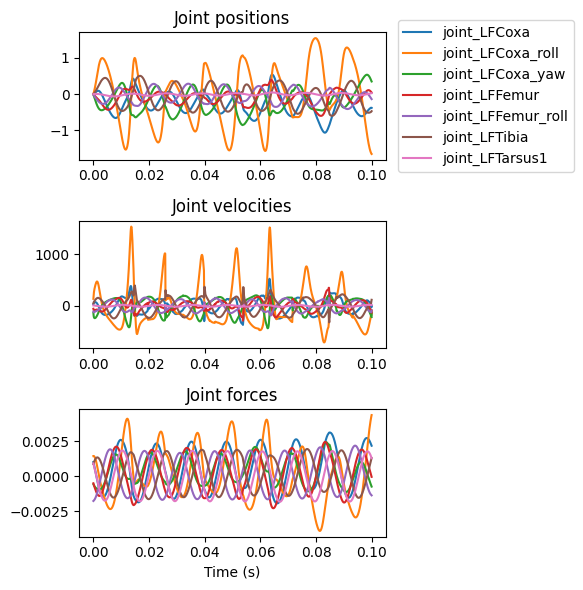

In [7]:
num_joints_to_plot = 7
t = np.arange(0, run_time, nmf.timestep)
fig, axs = plt.subplots(3, 1, figsize=(6, 6), tight_layout=True)
axs[0].plot(t, [x['joints'][0, :num_joints_to_plot] for x in obs_list],
            label=nmf.actuated_joints[:num_joints_to_plot])
axs[0].legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
axs[0].set_title('Joint positions')
axs[1].plot(t, [x['joints'][1, :num_joints_to_plot] for x in obs_list])
axs[1].set_title('Joint velocities')
axs[2].plot(t, [x['joints'][2, :num_joints_to_plot] for x in obs_list])
axs[2].set_xlabel('Time (s)')
axs[2].set_title('Joint forces')
plt.show()

As expected. Note that the joint position time series are not perfect sine waves. This is because we have a finite position gain factor that does not allow the physics to match the specified target positions perfectly.

Let's also inspect the time series of the fly's position:

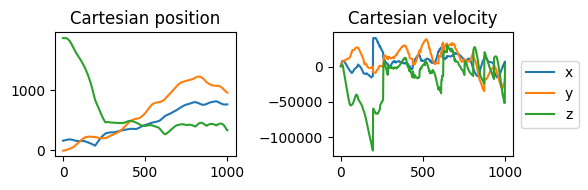

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2), tight_layout=True)
axs[0].plot([x['fly'][0, :] for x in obs_list])
axs[0].set_title('Cartesian position')
axs[1].plot([x['fly'][1, :] for x in obs_list], label=['x', 'y', 'z'])
axs[1].legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
axs[1].set_title('Cartesian velocity')
plt.show()

Similarly, let's inspect the time series of the fly's orientation:

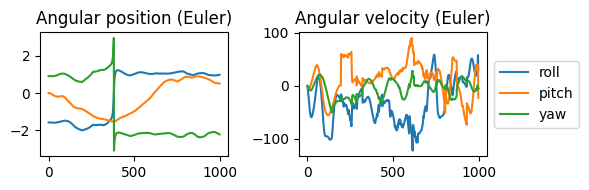

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2), tight_layout=True)
axs[0].plot([x['fly'][2, :] for x in obs_list], label=['roll', 'pitch', 'yaw'])
axs[0].set_title('Angular position (Euler)')
axs[1].plot([x['fly'][3, :] for x in obs_list],
               label=['roll', 'pitch', 'yaw'])
axs[1].legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
axs[1].set_title('Angular velocity (Euler)')
plt.show()

Note that the angles might warp to $-\pi$ when it exceeded $\pi$ (or vice versa), and the roll angle is rapidly changed by around $\pi$ (consistent with the fact that the fly flipped).

## Complex terrain

We have implemented slightly more complex terrain types. You can read more about it [here](https://nely-epfl.github.io/flygym/terrain/index.html).

 <img src="https://raw.githubusercontent.com/NeLy-EPFL/flygym/main/doc/source/_static/terrain.jpg" alt="Girl in a jacket" width="800"> 


First, we define a `load_fly` helper function to load and configure a NeuroMechFly model. This is not critical and you don't have to understand it.

In [10]:
#@title Define NeuroMechFly loader

import yaml
from dm_control import mjcf
from flygym.util.data import mujoco_groundwalking_model_path
from flygym.util.data import default_pose_path
from flygym.util.config import all_leg_dofs

def load_fly():
    # Load NMF model
    model = mjcf.from_path(mujoco_groundwalking_model_path)
    with open(default_pose_path) as f:
        init_pose = {k: np.deg2rad(v)
                        for k, v in yaml.safe_load(f)['joints'].items()}
    init_pose = {k: v for k, v in init_pose.items() if k in all_leg_dofs}

    # Set all bodies to default position (joint angle) even if the
    # joint is unactuated
    for body in model.find_all('body'):
        if (key := f'joint_{body.name}') in init_pose:
            if body.name.endswith('_yaw'):
                rot_axis = [1, 0, 0]
            elif body.name.endswith('_roll'):
                rot_axis = [0, 0, 1]
            else:    # pitch
                rot_axis = [0, 1, 0]
            # replace hardcoded quaternion with axis-angle
            del body.quat
            body.axisangle = [*rot_axis, init_pose[key]]
    
    return model

We can create a 'gapped' environment:

(-0.5, 319.5, 239.5, -0.5)

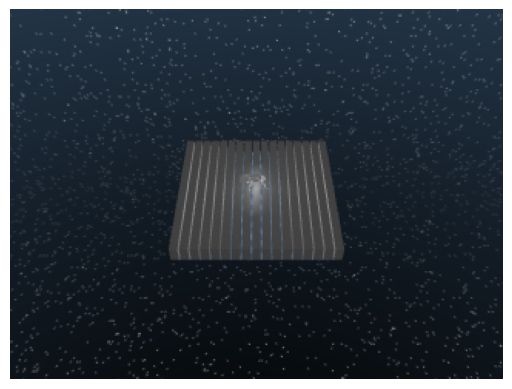

In [11]:
from flygym.terrain.mujoco_terrain import GappedTerrain

gapped = GappedTerrain()
model = load_fly()
gapped.spawn_entity(model, rel_pos=(0, 0, 600), rel_angle=(0, 1, 0, 0.1))
physics = mjcf.Physics.from_mjcf_model(gapped.arena)
plt.imshow(physics.render())
plt.axis('off')

We can also create a 'blocks' environment:

(-0.5, 319.5, 239.5, -0.5)

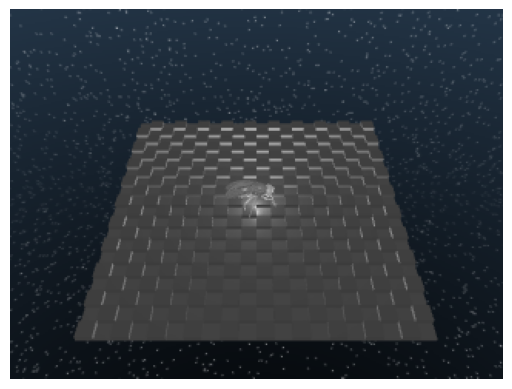

In [12]:
from flygym.terrain.mujoco_terrain import ExtrudingBlocksTerrain

box = ExtrudingBlocksTerrain()
model = load_fly()
box.spawn_entity(model, rel_pos=(0, 0, 600), rel_angle=(0, 1, 0, 0.1))
physics = mjcf.Physics.from_mjcf_model(box.arena)
plt.imshow(physics.render())
plt.axis('off')